In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.1
    Uninstalling ml-dtypes-0.3.1:
      Successfully uninstalled ml-dtypes-

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada VGG16 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

conv_base  = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False)


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip

Archive:  /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip
  inflating: ISICDatabase2/Aleatoriodatabase.py  
   creating: ISICDatabase2/Test/
   creating: ISICDatabase2/Test/basal cell carcinoma/
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024331.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024332.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024345.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024360.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024403.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024411.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024431.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024432.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024436.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024443.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024448.jpg 

Ajustando los datos de la BD


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'ISICDatabase2/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1308 files belonging to 4 classes.
Found 325 files belonging to 4 classes.
Found 64 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
import tensorflow as tf


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = conv_base(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(80,3,padding="same",activation="elu")(x)
x = tf.keras.layers.Conv2D(40,3,padding="same",activation="elu")(x)
x = tf.keras.layers.Conv2D(25,3,padding="same",activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(952, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                             

Fijar los hiperparámetros y entrenar la red

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'model20-12-2020_dp03031024.h5' #'/content'
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        #filepath=checkpoint_filepath,
        filepath='model20-12-2020_dp03031024.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1,
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,  #30
    validation_data=validation_dataset,
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/1000
41/41 [==============================] - ETA: 0s - loss: 24.1400 - accuracy: 0.4557
Epoch 1: val_accuracy improved from -inf to 0.52308, saving model to model20-12-2020_dp03031024.h5
41/41 [==============================] - 23s 149ms/step - loss: 24.1400 - accuracy: 0.4557 - val_loss: 20.4494 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 2/1000
41/41 [==============================] - ETA: 0s - loss: 15.7423 - accuracy: 0.5612
Epoch 2: val_accuracy improved from 0.52308 to 0.52615, saving model to model20-12-2020_dp03031024.h5
41/41 [==============================] - 4s 92ms/step - loss: 15.7423 - accuracy: 0.5612 - val_loss: 12.7811 - val_accuracy: 0.5262 - lr: 0.0010
Epoch 3/1000
41/41 [==============================] - ETA: 0s - loss: 9.4356 - accuracy: 0.6498
Epoch 3: val_accuracy did not improve from 0.52615
41/41 [==============================] - 4s 90ms/step - loss: 9.4356 - accuracy: 0.6498 - val_loss: 7.9658 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 4/1000
41/41 [===

Visualizando la pérdida y el accuracy durante el entrenamiento


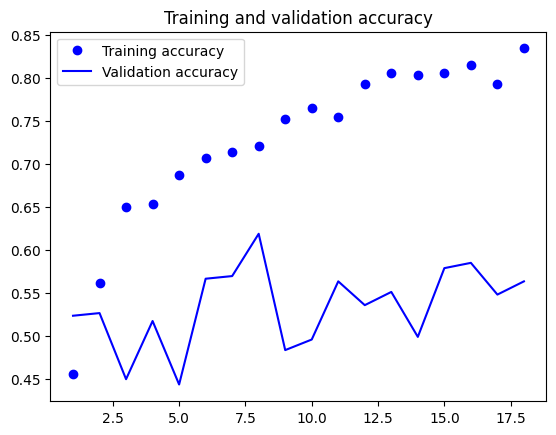

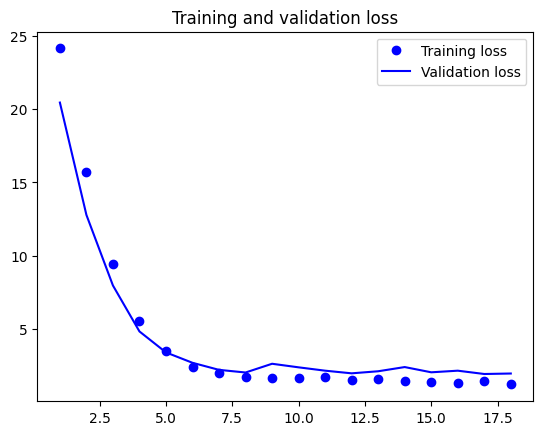

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
2/2 - 0s - loss: 1.8937 - accuracy: 0.6094 - 158ms/epoch - 79ms/step
Test Loss: 1.8936665058135986
Test Accuracy: 0.609375


### Matriz de confusión y métricas relevantes


In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 825ms/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[153  43   6  99]
 [  0 278  39  34]
 [  2  26 223  35]
 [  0  12   1 357]]


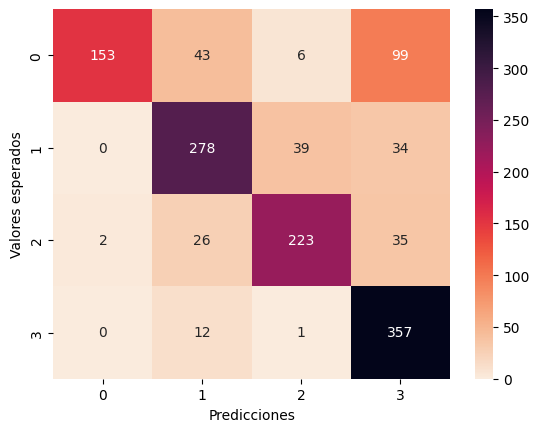

              precision    recall  f1-score   support

           0       0.99      0.51      0.67       301
           1       0.77      0.79      0.78       351
           2       0.83      0.78      0.80       286
           3       0.68      0.96      0.80       370

    accuracy                           0.77      1308
   macro avg       0.82      0.76      0.76      1308
weighted avg       0.81      0.77      0.77      1308



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 21ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[24 19  0 32]
 [ 0 45 23 19]
 [ 1 16 37 17]
 [ 1 13  1 77]]


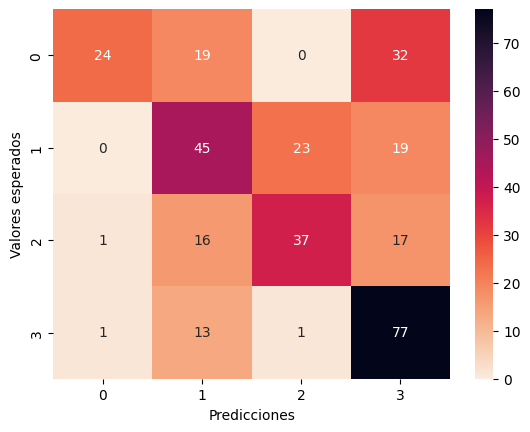

              precision    recall  f1-score   support

           0       0.92      0.32      0.48        75
           1       0.48      0.52      0.50        87
           2       0.61      0.52      0.56        71
           3       0.53      0.84      0.65        92

    accuracy                           0.56       325
   macro avg       0.64      0.55      0.55       325
weighted avg       0.63      0.56      0.55       325



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 26ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[ 8  3  0  5]
 [ 0  4  9  3]
 [ 0  0 15  1]
 [ 0  3  1 12]]


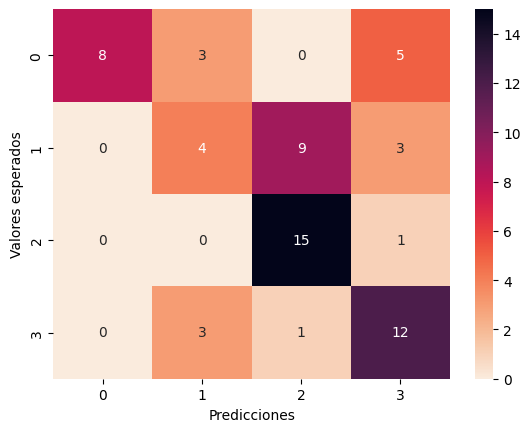

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        16
           1       0.40      0.25      0.31        16
           2       0.60      0.94      0.73        16
           3       0.57      0.75      0.65        16

    accuracy                           0.61        64
   macro avg       0.64      0.61      0.59        64
weighted avg       0.64      0.61      0.59        64



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))